# FR-Train on clean synthetic data

## how well does discriminator reflect MI?

## Import libraries

In [9]:
import sys, os
import numpy as np
import math
from sklearn.feature_selection import mutual_info_classif


os.chdir('/Users/songtengyu/Documents/2023Fall/Information theory/fr-train/')

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

import math
import matplotlib.pyplot as plt

from argparse import Namespace

from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model

import warnings
warnings.filterwarnings("ignore")

import pandas as pd

from knncmi import cmi

## Load and process data (using clean y train label)

In [10]:
# a namespace object which contains some of the hyperparameters
opt = Namespace(num_train=2000, num_val1=200, num_val2=500, num_test=1000)

In [11]:
num_train = opt.num_train
num_val1 = opt.num_val1
num_val2 = opt.num_val2
num_test = opt.num_test

X = np.load('./X_synthetic.npy') # Input features
y = np.load('./y_synthetic.npy') # Original labels
y_poi = np.load('./y_poi.npy') # Poisoned train labels
s1 = np.load('./s1_synthetic.npy') # Sensitive features

X = torch.FloatTensor(X)
y = torch.FloatTensor(y)
y_poi = torch.FloatTensor(y_poi)
s1 = torch.FloatTensor(s1)

X_train = X[:num_train - num_val1]
y_train = y_poi[:num_train - num_val1] # Poisoned label
s1_train = s1[:num_train - num_val1]

X_val = X[num_train: num_train + num_val1]
y_val = y[num_train: num_train + num_val1]
s1_val = s1[num_train: num_train + num_val1]

# Currently not used
# X_val2 = X[num_train + num_val1 : num_train + num_val1 + num_val2]
# y_val2 = y[num_train + num_val1 : num_train + num_val1 + num_val2]
# s1_val2 = s1[num_train + num_val1 : num_train + num_val1 + num_val2]

X_test = X[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]
y_test = y[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]
s1_test = s1[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]

XS_train = torch.cat([X_train, s1_train.reshape((s1_train.shape[0], 1))], dim=1)
XS_val = torch.cat([X_val, s1_val.reshape((s1_val.shape[0], 1))], dim=1)
XS_test = torch.cat([X_test, s1_test.reshape((s1_test.shape[0], 1))], dim=1)

In [12]:
print("--------------------- Number of Data -------------------------" )
print(
    "Train data : %d, Validation data : %d, Test data : %d "
    % (len(y_train), len(y_val), len(y_test))
)       
print("--------------------------------------------------------------")

--------------------- Number of Data -------------------------
Train data : 1800, Validation data : 200, Test data : 1000 
--------------------------------------------------------------


In [13]:
# def cal_MI_d_f(output, target, weight=None):
#     # output = output.detach().numpy()
#     # target = target.detach().numpy()
#     if weight is None:
#         weight = np.ones_like(target) / len(target)
#     else:
#         # Normalize weights to sum up to 1
#         weight = weight / np.sum(weight)
        
#     output_label = (output > 0).astype(float)
#     # Calculate weighted probabilities
#     p_s1 = np.sum(target * weight)
#     p_s0 = np.sum((1 - target) * weight)
#     p_y1 = np.sum(output_label * weight)
#     p_y0 = np.sum((1 - output_label) * weight)

#     p_s1y1 = np.sum(target * output_label * weight)
#     p_s1y0 = p_s1 - p_s1y1
#     p_s0y1 = p_y1 - p_s1y1
#     p_s0y0 = 1 - p_s1y1 - p_s1y0 - p_s0y1

#     # Calculate conditional probabilities
#     p_s1_given_y1 = p_s1y1 / p_y1 if p_y1 != 0 else 0
#     p_s1_given_y0 = p_s1y0 / p_y0 if p_y0 != 0 else 0
#     p_s0_given_y1 = p_s0y1 / p_y1 if p_y1 != 0 else 0
#     p_s0_given_y0 = p_s0y0 / p_y0 if p_y0 != 0 else 0

#     # Calculate entropies
#     H_S = -p_s1 * np.log(p_s1 + 1e-10) - p_s0 * np.log(p_s0 + 1e-10)
#     H_S_given_Y = -(p_s1y1
#                     * np.log(p_s1_given_y1 + 1e-10) +
#                     p_s1y0 * np.log(p_s1_given_y0 + 1e-10) +
#                     p_s0y1 * np.log(p_s0_given_y1 + 1e-10) +
#                     p_s0y0 * np.log(p_s0_given_y0 + 1e-10))

#     mi = H_S - H_S_given_Y

#     return mi

In [14]:
# def cal_MI_d_r(X, Y, S, Y_hat, label):
#     # X = X.detach().numpy()
#     # Y = Y.detach().numpy()
#     # S = S.detach().numpy()
#     # Y_hat = Y_hat.detach().numpy()
#     # label = label.detach().numpy()
    
#     df_tmp = pd.DataFrame({'X': X, 'Y': Y, 'S': S, 'Y_hat': Y_hat, 'label': label})
#     # mi_xq = cmi(['X'],['label'],[], 8, df_tmp)
#     # mi_yq_given_x = cmi(['Y'],['label'],['Y'], 8, df_tmp)
#     # mi_zq_given_xy = cmi(['S'],['label'],['X', 'Y'], 8, df_tmp)
#     mi_yhatq_given_xys = cmi(['Y_hat'],['label'],['X', 'Y', 'S'], 8, df_tmp)
#     return mi_yhatq_given_xys

# Training with clean data

In [24]:
def cal_MI_d_f(output, target, weight=None):
    # output = output.detach().numpy()
    # target = target.detach().numpy()
    if weight is None:
        weight = np.ones_like(target) / len(target)
    else:
        # Normalize weights to sum up to 1
        weight = weight / np.sum(weight)
        
    output_label = (output > 0).astype(float)
    # Calculate weighted probabilities
    p_s1 = np.sum(target * weight)
    p_s0 = np.sum((1 - target) * weight)
    p_y1 = np.sum(output_label * weight)
    p_y0 = np.sum((1 - output_label) * weight)

    p_s1y1 = np.sum(target * output_label * weight)
    p_s1y0 = p_s1 - p_s1y1
    p_s0y1 = p_y1 - p_s1y1
    p_s0y0 = 1 - p_s1y1 - p_s1y0 - p_s0y1

    # Calculate conditional probabilities
    p_s1_given_y1 = p_s1y1 / p_y1 if p_y1 != 0 else 0
    p_s1_given_y0 = p_s1y0 / p_y0 if p_y0 != 0 else 0
    p_s0_given_y1 = p_s0y1 / p_y1 if p_y1 != 0 else 0
    p_s0_given_y0 = p_s0y0 / p_y0 if p_y0 != 0 else 0

    # Calculate entropies
    H_S = -p_s1 * np.log(p_s1 + 1e-10) - p_s0 * np.log(p_s0 + 1e-10)
    H_S_given_Y = -(p_s1y1
                    * np.log(p_s1_given_y1 + 1e-10) +
                    p_s1y0 * np.log(p_s1_given_y0 + 1e-10) +
                    p_s0y1 * np.log(p_s0_given_y1 + 1e-10) +
                    p_s0y0 * np.log(p_s0_given_y0 + 1e-10))

    mi = H_S - H_S_given_Y

    return mi

def cal_MI_d_r(X, Y, S, Y_hat, label):
    # X = X.detach().numpy()
    # Y = Y.detach().numpy()
    # S = S.detach().numpy()
    # Y_hat = Y_hat.detach().numpy()
    # label = label.detach().numpy()
    
    df_tmp = pd.DataFrame({'X': X, 'Y': Y, 'S': S, 'Y_hat': Y_hat, 'label': label})
    # mi_xq = cmi(['X'],['label'],[], 8, df_tmp)
    # mi_yq_given_x = cmi(['Y'],['label'],['Y'], 8, df_tmp)
    # mi_zq_given_xy = cmi(['S'],['label'],['X', 'Y'], 8, df_tmp)
    mi_yhatq_given_xys = cmi(['Y_hat'],['label'],['X', 'Y', 'S'], 8, df_tmp)
    return mi_yhatq_given_xys

In [25]:
def train_model(train_tensors, val_tensors, test_tensors, train_opt, lambda_f, lambda_r, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        val_tensors: Clean validation data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        lambda_r: The tuning knob for L_3 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f, lambda_r),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_val = val_tensors.XS_val
    y_val = val_tensors.y_val
    s1_val = val_tensors.s1_val
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    
    # Changes the input validation data to an appropriate shape for the training
    XSY_val = torch.cat([XS_val, y_val.reshape((y_val.shape[0], 1))], dim=1)  

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    
    d_f_losses = []
    d_r_losses = []
    d_f_mi = []
    d_r_mi = []
    d_r_mi2 = []
    clean_test_result = []

    bce_loss = torch.nn.BCELoss()

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF()
    discriminator_R = DiscriminatorR()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)
    discriminator_R.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.SGD(discriminator_F.parameters(), lr=train_opt.lr_f)
    optimizer_D_R = torch.optim.SGD(discriminator_R.parameters(), lr=train_opt.lr_r)

    XSY_val_data = XSY_val[:val]

    train_len = XS_train.shape[0]
    val_len = XSY_val.shape[0]

    # Ground truths using in Disriminator_R
    Tensor = torch.FloatTensor
    valid = Variable(Tensor(train_len, 1).fill_(1.0), requires_grad=False)
    generated = Variable(Tensor(train_len, 1).fill_(0.0), requires_grad=False)
    fake = Variable(Tensor(train_len, 1).fill_(0.0), requires_grad=False)
    clean = Variable(Tensor(val_len, 1).fill_(1.0), requires_grad=False)
    
    r_weight = torch.ones_like(y_train, requires_grad=False).float()
    r_ones = torch.ones_like(y_train, requires_grad=False).float()

    for epoch in range(n_epochs):
        # -------------------
        # Mutual Information estimation
        # -------------------
        gen_y = generator(XS_train)
        # gen_data = torch.cat([XS_train, gen_y.detach().reshape((gen_y.shape[0], 1))], dim=1)
        
        # Discriminator_F 
        df_mi_tmp = cal_MI_d_f(gen_y.squeeze().detach().numpy(), s1_train.squeeze().detach().numpy())
        d_f_mi.append(df_mi_tmp)
        # print("MI Dis F: ", mi_tmp)
        
        # Discriminator_R
        X_tmp0 = XS_train[:, 0].detach().numpy()
        Y_tmp0 = XS_train[:, 1].detach().numpy()
        S_tmp0 = XS_train[:, 2].detach().numpy()
        yhat_tmp0 = (gen_y.squeeze().detach().numpy() > 0).astype(float)
        label_tmp0 = np.zeros_like(X_tmp0)
        
        X_tmp1 = XSY_val_data[:, 0].detach().numpy()
        Y_tmp1 = XSY_val_data[:, 1].detach().numpy()
        S_tmp1 = XSY_val_data[:, 2].detach().numpy()
        yhat_tmp1 = XSY_val_data[:, 3].detach().numpy()
        label_tmp1 = np.ones_like(X_tmp1)
        
        X_tmp = np.concatenate((X_tmp0, X_tmp1))
        Y_tmp = np.concatenate((Y_tmp0, Y_tmp1))
        S_tmp = np.concatenate((S_tmp0, S_tmp1))
        yhat_tmp = np.concatenate((yhat_tmp0, yhat_tmp1))
        label_tmp = np.concatenate((label_tmp0, label_tmp1))
        
        dr_mi_tmp = cal_MI_d_r(X_tmp, Y_tmp, S_tmp, yhat_tmp, label_tmp)
        d_r_mi.append(dr_mi_tmp)
        
        dr_mi_tmp2 = cal_MI_d_f(yhat_tmp, label_tmp)
        d_r_mi2.append(dr_mi_tmp2)

        # -------------------
        #  Forwards Generator
        # -------------------
        if epoch % k == 0 or epoch < 500:
            optimizer_G.zero_grad()

        gen_y = generator(XS_train)
        gen_data = torch.cat([XS_train, gen_y.reshape((gen_y.shape[0], 1))], dim=1)


        # -------------------------------
        #  Trains Fairness Discriminator
        # -------------------------------

        optimizer_D_F.zero_grad()
        
        # Discriminator_F tries to distinguish the sensitive groups by using the output of the generator.
        d_f_loss = bce_loss(discriminator_F(gen_y.detach()).squeeze(), s1_train)
        d_f_loss.backward()
        d_f_losses.append(d_f_loss)
        optimizer_D_F.step()
            
            
        # ---------------------------------
        #  Trains Robustness Discriminator
        # ---------------------------------
        optimizer_D_R.zero_grad()

        # Discriminator_R tries to distinguish whether the input is from the validation data or the generated data from generator.
        clean_loss =  bce_loss(discriminator_R(XSY_val_data), clean)
        poison_loss = bce_loss(discriminator_R(gen_data.detach()), fake)
        d_r_loss = 0.5 * (clean_loss + poison_loss)

        d_r_loss.backward()
        d_r_losses.append(d_r_loss)
        optimizer_D_R.step()

        
        # ---------------------
        #  Updates Generator
        # ---------------------


        if epoch < 500 :
            g_loss = 0.1 * bce_loss((F.tanh(gen_y).squeeze()+1)/2, (y_train+1)/2)
            g_loss.backward()
            g_losses.append(g_loss)
            optimizer_G.step()
        elif epoch % k == 0:
            r_decision = discriminator_R(gen_data)
            r_gen = bce_loss(r_decision, generated)
            
            # ---------------------------------
            #  Re-weights using output of D_R
            # ---------------------------------
            if epoch % 100 == 0:
                loss_ratio = (g_losses[-1]/d_r_losses[-1]).detach()
                a = 1/(1+torch.exp(-(loss_ratio-3)))
                b = 1-a
                r_weight_tmp = r_decision.detach().squeeze()
                r_weight = a * r_weight_tmp + b * r_ones

            f_cost = F.binary_cross_entropy(discriminator_F(gen_y).squeeze(), s1_train, reduction="none").squeeze()
            g_cost = F.binary_cross_entropy_with_logits(gen_y.squeeze(), (y_train.squeeze()+1)/2, reduction="none").squeeze()

            f_gen = torch.mean(f_cost*r_weight)
            g_loss = (1-lambda_f-lambda_r) * torch.mean(g_cost*r_weight) - lambda_f * f_gen -  lambda_r * r_gen 

            g_loss.backward()
            optimizer_G.step()


        g_losses.append(g_loss)

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [D_F loss: %f] [D_R loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, d_f_losses[-1], d_r_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    tmp = test_model(generator, XS_test, y_test, s1_test)
    test_result.append([lambda_f, lambda_r, tmp[0].item(), tmp[1]])

    return test_result, d_f_losses, d_r_losses, d_f_mi, d_r_mi, d_r_mi2, g_losses

In [26]:
train_tensors = Namespace(XS_train = XS_train, y_train = y_train, s1_train = s1_train)
val_tensors = Namespace(XS_val = XS_val, y_val = y_val, s1_val = s1_val) 
test_tensors = Namespace(XS_test = XS_test, y_test = y_test, s1_test = s1_test)

train_opt = Namespace(val=len(y_val), n_epochs=10000, k=5, lr_g=0.001, lr_f=0.001, lr_r=0.001)      
seed = 1 

test_result, d_f_losses, d_r_losses, d_f_mi, d_r_mi, d_r_mi2, g_losses = train_model(train_tensors, val_tensors, test_tensors, train_opt, lambda_f = 0.52, lambda_r = 0.4, seed=seed)

[Lambda: 0.520000] [Epoch 0/10000] [D_F loss: 0.686340] [D_R loss: 0.716233] [G loss: 0.060358]
[Lambda: 0.520000] [Epoch 200/10000] [D_F loss: 0.682480] [D_R loss: 0.705211] [G loss: 0.057829]
[Lambda: 0.520000] [Epoch 400/10000] [D_F loss: 0.679608] [D_R loss: 0.698599] [G loss: 0.057678]
[Lambda: 0.520000] [Epoch 600/10000] [D_F loss: 0.689413] [D_R loss: 0.702650] [G loss: -0.617675]
[Lambda: 0.520000] [Epoch 800/10000] [D_F loss: 0.708825] [D_R loss: 0.711040] [G loss: -0.622047]
[Lambda: 0.520000] [Epoch 1000/10000] [D_F loss: 0.713561] [D_R loss: 0.710284] [G loss: -0.617979]
[Lambda: 0.520000] [Epoch 1200/10000] [D_F loss: 0.707583] [D_R loss: 0.704548] [G loss: -0.609954]
[Lambda: 0.520000] [Epoch 1400/10000] [D_F loss: 0.696940] [D_R loss: 0.697852] [G loss: -0.601033]
[Lambda: 0.520000] [Epoch 1600/10000] [D_F loss: 0.687138] [D_R loss: 0.692088] [G loss: -0.593741]
[Lambda: 0.520000] [Epoch 1800/10000] [D_F loss: 0.681830] [D_R loss: 0.687906] [G loss: -0.589522]
[Lambda: 0

In [27]:
import pickle

with open('FR-Train_poi_loss_mi.pkl', 'wb') as f:
    pickle.dump([test_result, d_f_losses, d_r_losses, d_f_mi, d_r_mi, d_r_mi2, g_losses], f)

In [28]:
len(d_f_losses), len(d_r_losses), len(d_f_mi), len(d_r_mi), len(g_losses)

(10000, 10000, 10000, 10000, 10500)

In [29]:
g_losses_first_1000 = g_losses[:1000]
g_losses_other = g_losses[1000:]

# keep only the odd indices of g_losses_first_1000
g_losses_first_1000_odd = g_losses_first_1000[1::2]
g_losses = g_losses_first_1000_odd + g_losses_other

len(d_f_losses), len(d_r_losses), len(d_f_mi), len(d_r_mi), len(g_losses)

(10000, 10000, 10000, 10000, 10000)

In [31]:
d_f_losses = [x.item() for x in d_f_losses]
d_r_losses = [x.item() for x in d_r_losses]
d_f_mi = [x for x in d_f_mi]
d_r_mi = [x for x in d_r_mi]
g_losses = [x.item() for x in g_losses]

In [32]:
df_dict = {'d_f_losses': d_f_losses, 'd_r_losses': d_r_losses, 'd_f_mi': d_f_mi, 'd_r_mi': d_r_mi, 'g_losses': g_losses}
df_all = pd.DataFrame(df_dict)
df_all.to_csv('./FR-Train_poi_loss_mi.csv', index=False)

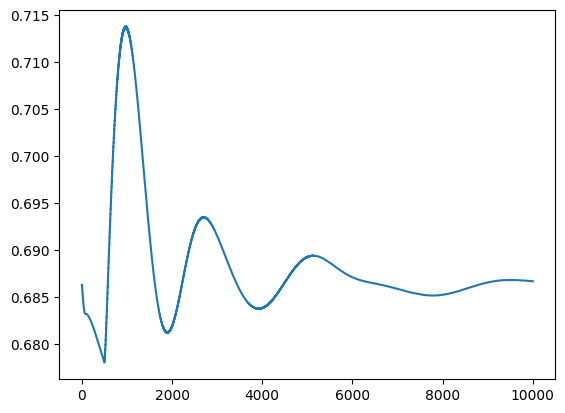

In [33]:
plt.plot(d_f_losses)

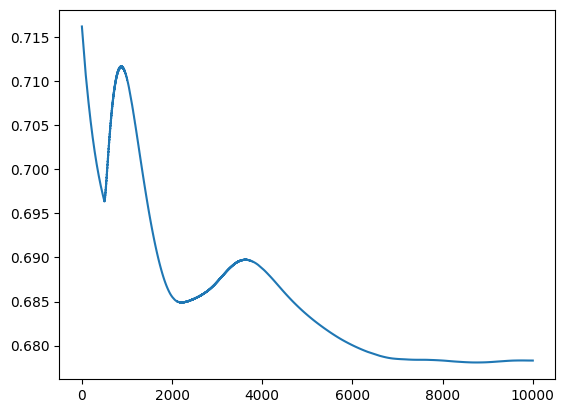

In [34]:
plt.plot(d_r_losses)

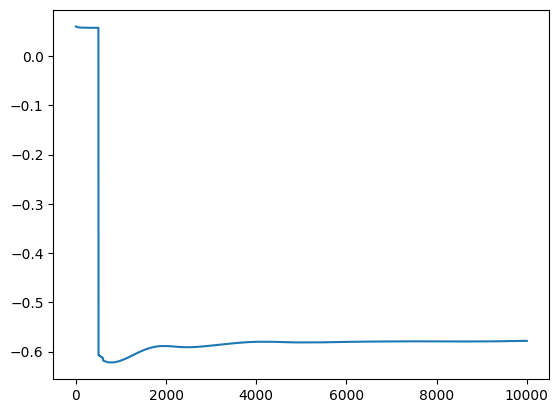

In [35]:
plt.plot(g_losses)

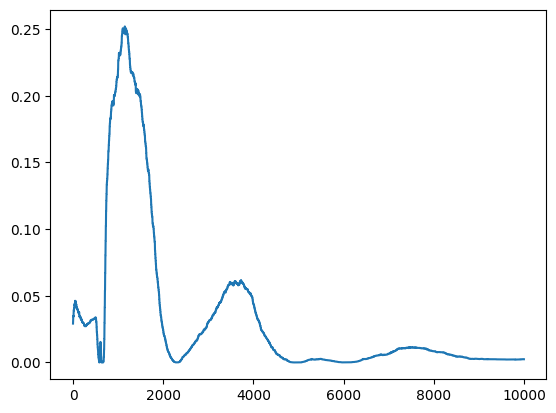

In [36]:
plt.plot(d_f_mi)

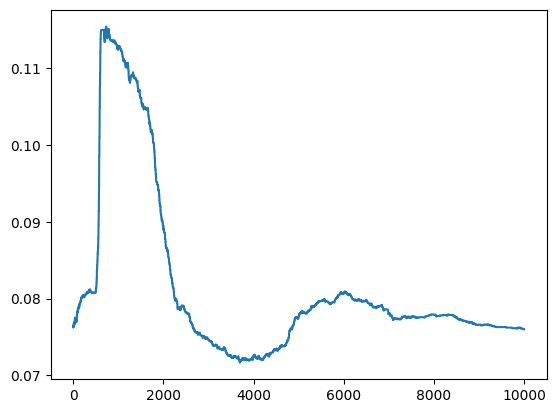

In [37]:
plt.plot(d_r_mi)

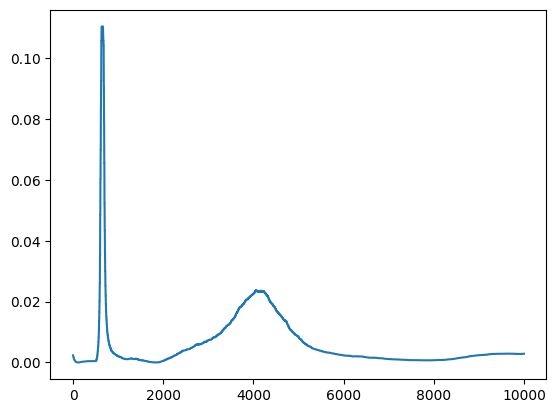

In [38]:
plt.plot(d_r_mi2)

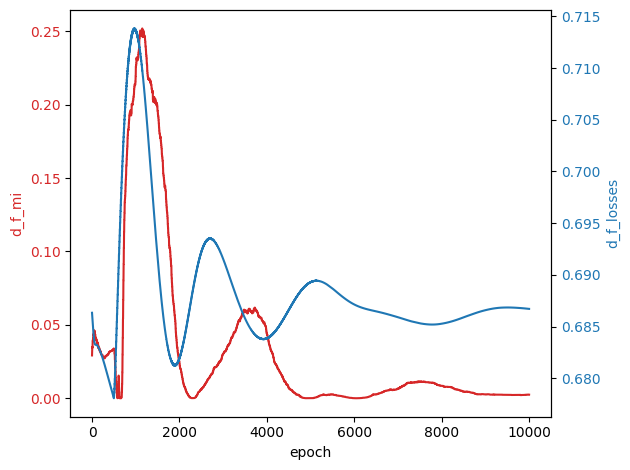

In [39]:
# plot d_f_mi and d_f_losses in a single plot but with different y-axis
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('d_f_mi', color=color)
ax1.plot(d_f_mi, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('d_f_losses', color=color)  # we already handled the x-label with ax1
ax2.plot(d_f_losses, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

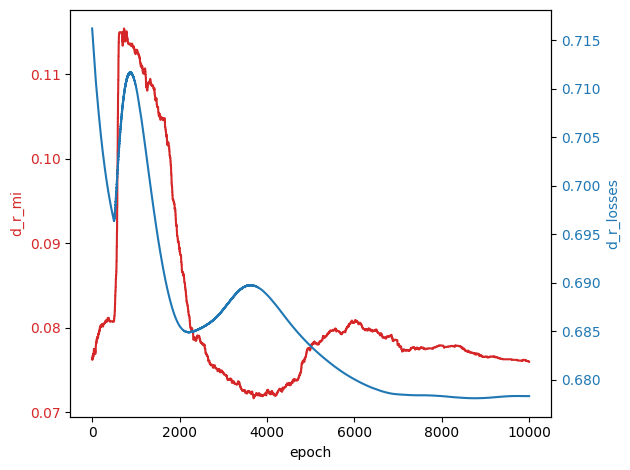

In [40]:
# plot d_f_mi and d_f_losses in a single plot but with different y-axis
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('d_r_mi', color=color)
ax1.plot(d_r_mi, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('d_r_losses', color=color)  # we already handled the x-label with ax1
ax2.plot(d_r_losses, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()